# Проверка гипотез

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway


# Загрузка данных о поездках и о погоде

In [2]:
rides_df = pd.read_csv('data/processing_rides.csv', parse_dates=['start_date', 'end_date'])
print(f"Данные о поездках загружены. Количество записей: {len(rides_df)}")

weather_df = pd.read_csv('data/weather_processed.csv', parse_dates=['datetime'])
print(f"Данные о погоде загружены. Количество записей: {len(weather_df)}")

FileNotFoundError: [Errno 2] No such file or directory: 'data/processing_rides.csv'

# Подготавливаем данные для работы

In [ ]:
df = rides_df.copy()

# Добавляем полезные признаки
df['hour'] = df['start_date'].dt.hour
df['day_of_week'] = df['start_date'].dt.dayofweek  # 0 = понедельник, 6 = воскресенье
df['date'] = df['start_date'].dt.date
df['day_type'] = df['day_of_week'].apply(lambda x: 'выходной' if x >= 5 else 'будний')

# Рассчитываем скорость (м/с)
df['speed_mps'] = df['distance'] / df['duration']  # метры в секунду
df['speed_kmh'] = df['speed_mps'] * 3.6  # км/ч

# Рассчитываем продолжительность в минутах для удобства
df['duration_min'] = df['duration'] / 60

# Показываем основные статистики
print("\nОсновные статистики данных:")
print(df[['distance', 'duration_min', 'speed_kmh']].describe())



Основные статистики данных:
           distance  duration_min     speed_kmh
count  93840.000000  93840.000000  93840.000000
mean    3823.431256     26.368847      9.190194
std     1029.632230      9.943114      2.023263
min      519.000000      2.566667      2.279973
25%     3108.000000     19.483333      7.834719
50%     3734.000000     24.616667      9.182206
75%     4443.000000     31.216667     10.532788
max    12548.131102     84.833333     19.122772


# КОНСТАНТЫ

In [ ]:
COST_START = 30
PROMO_START_TIME = 6
PROMO_END_TIME = 10

# Гипотеза 1: Верно ли, что в дождливое время спрос на самокаты ниже?

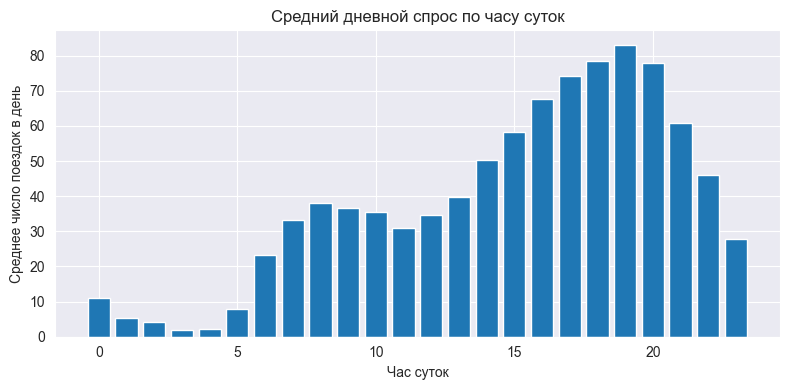

In [ ]:
df_rides = rides_df.copy()
df_weather = weather_df.copy()


# сколько дней в выборке
n_days = df_rides['start_date'].dt.date.nunique()

demand_by_hour_of_day = (
    df_rides
    .groupby(df_rides['start_date'].dt.hour)
    .size()
    .reset_index(name='total_trips')
)

demand_by_hour_of_day['mean_trips_per_day'] = (
    demand_by_hour_of_day['total_trips'] / n_days
)

# Визуализация
plt.figure(figsize=(8, 4))
plt.bar(demand_by_hour_of_day['start_date'],  # это час
        demand_by_hour_of_day['mean_trips_per_day'])
plt.xlabel('Час суток')
plt.ylabel('Среднее число поездок в день')
plt.title('Средний дневной спрос по часу суток')
plt.tight_layout()
plt.show()

## Статистическая проверка гипотезы 1

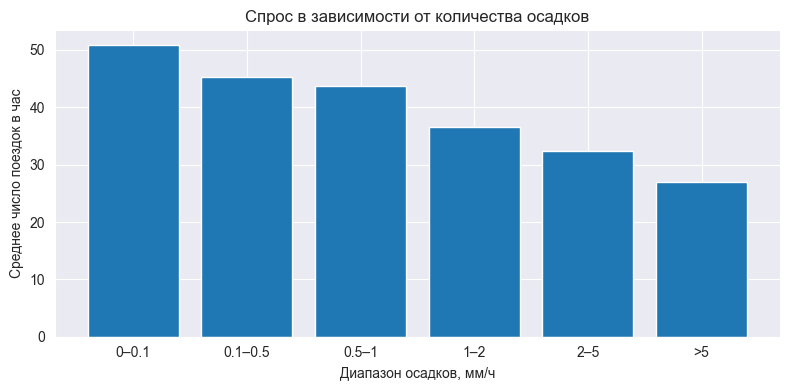

In [ ]:
# округляем время до часа
df_rides['hour'] = df_rides['start_date'].dt.floor('h')
df_weather['hour'] = df_weather['datetime'].dt.floor('h')

demand_hourly = (
    df_rides
    .groupby('hour')
    .size()
    .reset_index(name='demand')
)

weather_hourly = (
    df_weather
    .groupby('hour', as_index=False)[
        ['temperature', 'precipitation_total',
         'wind_speed', 'cloud_cover_total', 'sunshine_duration']
    ].mean()
)
    
df_demand_weather = demand_hourly.merge(weather_hourly, on='hour', how='left')
df_demand_weather = df_demand_weather.sort_values('hour').reset_index(drop=True)
df_demand_weather['hour'] = pd.to_datetime(df_demand_weather['hour'])

df_demand_weather['hour_of_day'] = df_demand_weather['hour'].dt.hour           # час в сутках (0–23)
df_demand_weather['day_of_week'] = df_demand_weather['hour'].dt.dayofweek      # день недели, 0 = понедельник
df_demand_weather['is_weekend'] = (df_demand_weather['day_of_week'] >= 5).astype(int)

# смотрим максимум, чтобы последний бин был чуть выше
mask = (df_demand_weather['hour_of_day'] >= 6) & (df_demand_weather['hour_of_day'] <= 23)
df_day = df_demand_weather[mask].copy()
max_precip = df_day['precipitation_total'].max()
bins = [0.0, 0.1, 0.5, 1, 2, 5, max_precip + 1e-6]
labels = ['0–0.1', '0.1–0.5', '0.5–1', '1–2', '2–5', '>5']

df_day['precip_bin'] = pd.cut(
    df_day['precipitation_total'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

demand_by_precip = (
    df_day.groupby('precip_bin', observed=True)['demand']
          .mean()
          .reset_index()
)

# Визуализация
plt.figure(figsize=(8, 4))
plt.bar(demand_by_precip['precip_bin'],
        demand_by_precip['demand'])
plt.xlabel('Диапазон осадков, мм/ч')
plt.ylabel('Среднее число поездок в час')
plt.title('Спрос в зависимости от количества осадков')
plt.tight_layout()
plt.show()

 Да, чем сильнее дождь, тем меньше поездок

# Гипозеза 2: Отличается ли средняя стоимость поездки по районам?

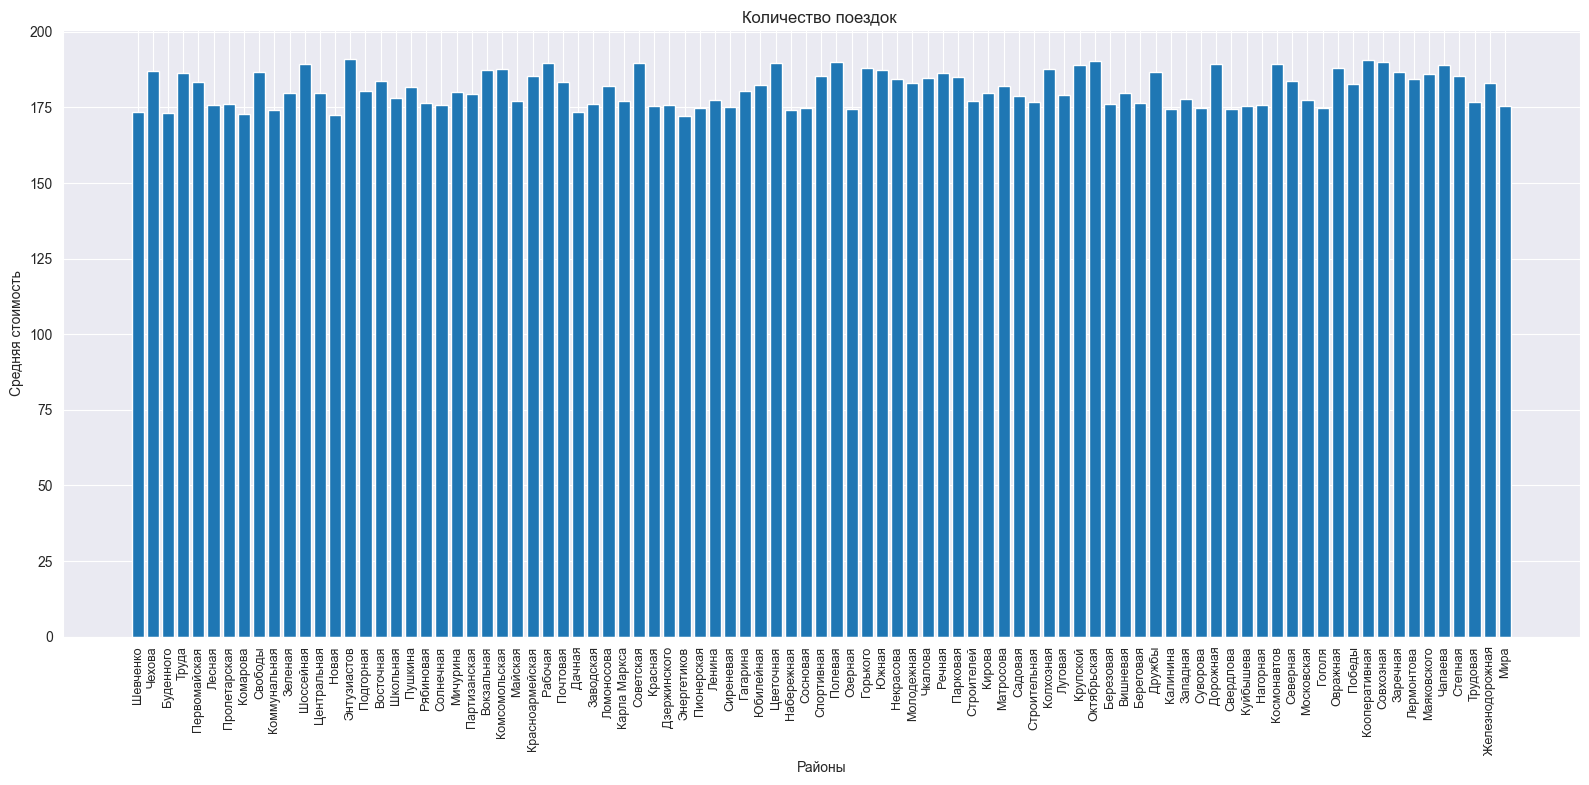

In [ ]:
# подготовка таблицы со стоимостью
data = {
    'Пн-Пт': [3, 4, 5, 6, 5],
    'Сб-Вс': [3, 4, 6, 7, 6]
}

time_intervals = [
    '01:00-06:00',
    '06:00-10:00',
    '10:00-16:00',
    '16:00-22:00',
    '22:00-01:00'
]

df_dynamic_costs = pd.DataFrame(data, index=time_intervals)

# Создаем функцию, которая вычисляет интервал времени
def get_cost_per_minute(start_date):
    hour = int(start_date.hour)
    day_of_week = int(start_date.dayofweek)
    day_type = 'Пн-Пт' if day_of_week < 5 else "Сб-Вс"

    time_interval = '22:00-01:00'
    if hour >= 1 and hour < 6:
        time_interval = '01:00-06:00'
    elif hour >= 6 and hour < 10:
        time_interval = '06:00-10:00'
    elif hour >= 10 and hour < 16:
        time_interval = '10:00-16:00'
    elif hour >= 16 and hour < 22:
        time_interval = '16:00-22:00'

    cost_per_min = df_dynamic_costs.loc[time_interval, day_type]
    return cost_per_min


# Итоговая стоимость = старт (30 руб.) + длительность (мин) * стоимость минуты (руб./мин)
# По понедельникам с 6:00 до 10:00 акция «Бесплатный старт» по промо-коду

def calculate_cost(row):
    # переводим длительность в минуты с округлением вверх (если проехали хоть лишнюю секунду платим за всю минуту)
    duration_minutes = np.ceil(row['duration'] / 60)

    # получаем стоимость за минуту
    cost_per_minute = get_cost_per_minute(row['start_date'])

    #считаем цену без промокода
    total_cost = cost_per_minute * duration_minutes + COST_START

    # определяем день недели
    day_of_week = int(row['start_date'].dayofweek)

    # получаем час поездки
    hour = int(row['start_date'].hour)

    # если промокод активен вычитаем стоимость старта
    if day_of_week == 0 and (hour >= PROMO_START_TIME and hour < PROMO_END_TIME) and row['promo'] == 1:
        total_cost -= COST_START

    return total_cost


df_rides['cost'] = df_rides.apply(calculate_cost, axis=1)

average_cost_start = df_rides.groupby('start_location')['cost'].mean()

unique_locations = df_rides['start_location'].unique()

# Визуализация

plt.figure(figsize=(16, 7))
plt.bar(unique_locations,
        average_cost_start)
plt.xlabel('Районы')
plt.ylabel('Средняя стоимость')
plt.title('Количество поездок ')
plt.tight_layout()
plt.xticks(rotation=90, fontsize=9)
plt.show()

## Статистическая проверка гипотезы 2

In [ ]:
# Создание списка данных для ANOVA
data_for_anova = [df_rides[df_rides['start_location'] == location]['cost'] for location in unique_locations]

# Проведение ANOVA
f_statistic, p_value = f_oneway(*data_for_anova)

# Вывод результатов
print(f'F-статистика: {f_statistic}')
print(f'P-значение: {p_value}')

if p_value < 0.05:
    print("Средние стоимости по районам различаются.")
else:
    print("Средние стоимости по районам не различаются.")

F-статистика: 8.212837354585524
P-значение: 3.911227400864514e-102


Различие очень мало, но есть; средняя стоимость во всех районах варьируется около 180р

# Гипотеза 3: Спрос на самокаты меняется в зависимости от дня недели


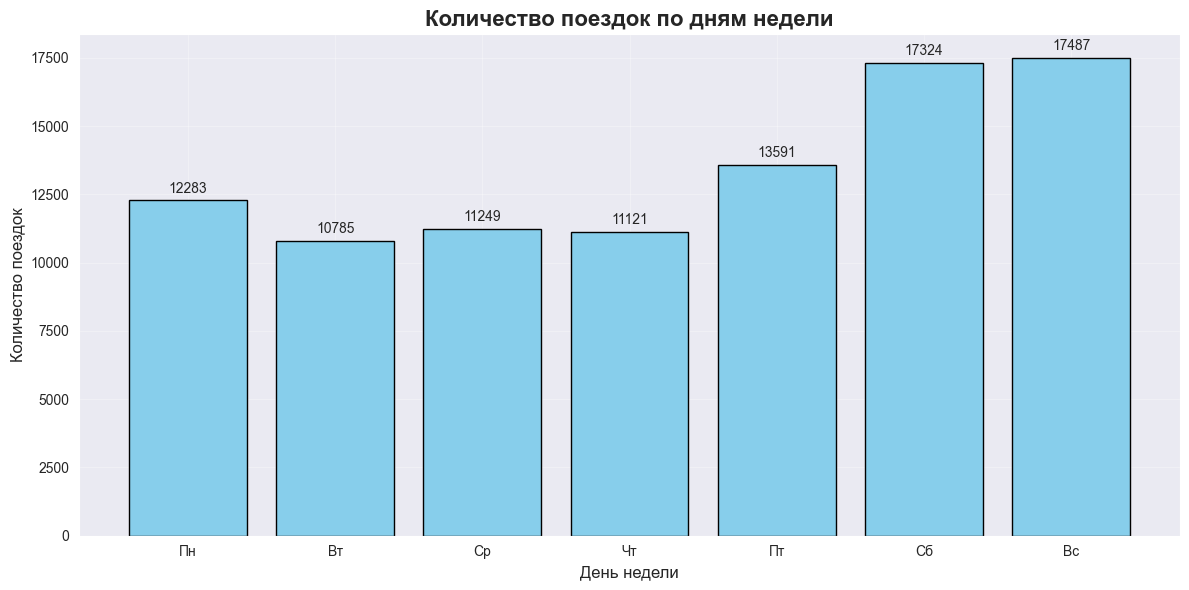

In [ ]:
# Группируем по дням недели
daily_counts = df.groupby('day_of_week').size().reset_index(name='count')
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
daily_counts['day_name'] = daily_counts['day_of_week'].apply(lambda x: day_names[x])

# Визуализация
plt.figure(figsize=(12, 6))
bars = plt.bar(daily_counts['day_name'], daily_counts['count'], color='skyblue', edgecolor='black')
plt.title('Количество поездок по дням недели', fontsize=16, fontweight='bold')
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + max(daily_counts['count']) * 0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Статистическая проверка гипотезы 3

In [ ]:
print("Гипотеза 3: Спрос на самокаты меняется в зависимости от дня недели")
print("=" * 60)

# Тест на равномерность распределения (хи-квадрат)
observed = daily_counts['count'].values
# Ожидаемое равномерное распределение
expected = np.full(len(observed), observed.mean())

chi2_stat, p_value = stats.chisquare(observed, expected)
print(f"Хи-квадрат статистика: {chi2_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"✓ Гипотеза подтверждается: распределение поездок по дням недели НЕ равномерно (p={p_value:.4f})")
else:
    print(f"✗ Гипотеза отвергается: распределение поездок по дням недели равномерно (p={p_value:.4f})")

# Дополнительный анализ: определяем самый популярный день
most_popular_day = daily_counts.loc[daily_counts['count'].idxmax()]
least_popular_day = daily_counts.loc[daily_counts['count'].idxmin()]
print(f"\nСамый популярный день: {most_popular_day['day_name']} ({most_popular_day['count']} поездок)")
print(f"Самый непопулярный день: {least_popular_day['day_name']} ({least_popular_day['count']} поездок)")


Гипотеза 3: Спрос на самокаты меняется в зависимости от дня недели
Хи-квадрат статистика: 3733.0464
P-значение: 0.0000
✓ Гипотеза подтверждается: распределение поездок по дням недели НЕ равномерно (p=0.0000)

Самый популярный день: Вс (17487 поездок)
Самый непопулярный день: Вт (10785 поездок)


В выходные и пятницу поездок заметно больше ≈ в 1,6 раз

# Гипотеза 4: Верно ли, что в выходные дни поездки более длительные?

C:\Users\TED\AppData\Local\Temp\ipykernel_2792\337129784.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='day_type', y='duration_min', ax=axes[0], palette='Set2')


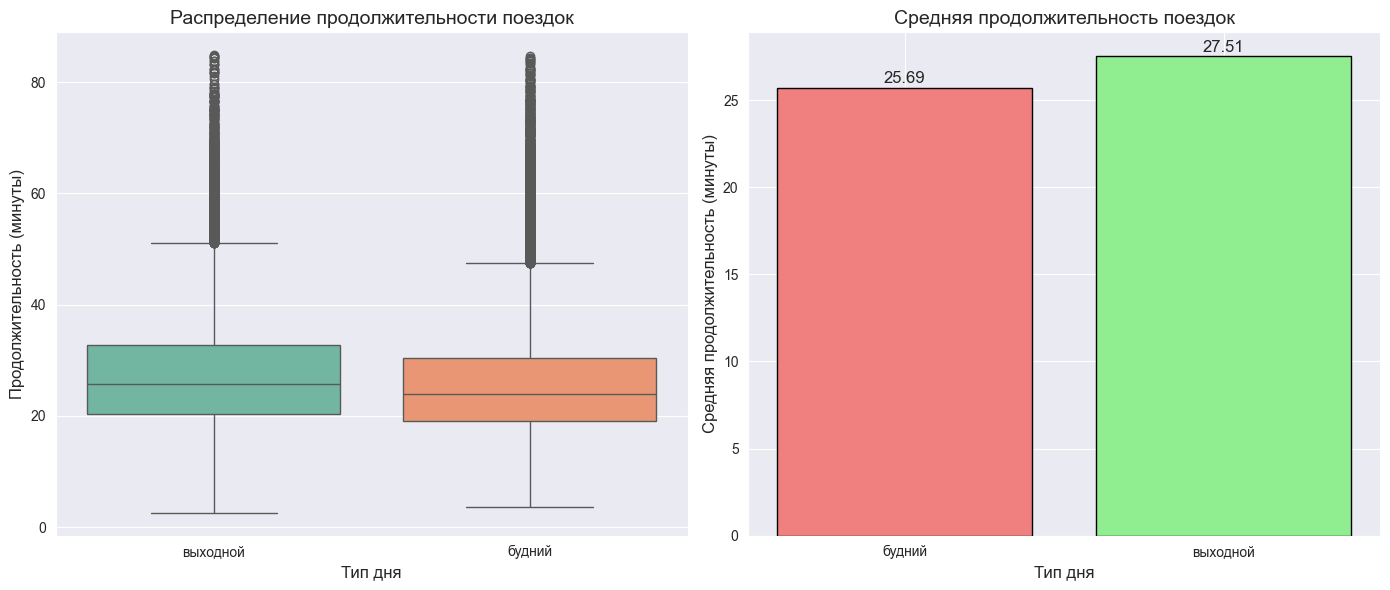

In [ ]:
# Сравнение продолжительности поездок в выходные и будни
duration_by_day_type = df.groupby('day_type')['duration_min'].agg(['mean', 'median', 'std', 'count']).round(2)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
sns.boxplot(data=df, x='day_type', y='duration_min', ax=axes[0], palette='Set2')
axes[0].set_title('Распределение продолжительности поездок', fontsize=14)
axes[0].set_xlabel('Тип дня', fontsize=12)
axes[0].set_ylabel('Продолжительность (минуты)', fontsize=12)

# Bar plot средних значений
means = df.groupby('day_type')['duration_min'].mean()
axes[1].bar(means.index, means.values, color=['lightcoral', 'lightgreen'], edgecolor='black')
axes[1].set_title('Средняя продолжительность поездок', fontsize=14)
axes[1].set_xlabel('Тип дня', fontsize=12)
axes[1].set_ylabel('Средняя продолжительность (минуты)', fontsize=12)

# Добавляем значения на столбцы
for i, (idx, val) in enumerate(means.items()):
    axes[1].text(i, val + 0.1, f'{val:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


## Статистическая проверка гипотезы 4

In [ ]:
print("Гипотеза 4: Верно ли, что в выходные дни поездки более длительные?")
print("=" * 60)

# Разделяем данные
weekday_durations = df[df['day_type'] == 'будний']['duration_min']
weekend_durations = df[df['day_type'] == 'выходной']['duration_min']

# Проверка нормальности распределения (тест Шапиро-Уилка)
print("Проверка нормальности распределения:")
with np.errstate(over='ignore'):
    _, p_weekday = stats.shapiro(weekday_durations.sample(min(5000, len(weekday_durations))))
    _, p_weekend = stats.shapiro(weekend_durations.sample(min(5000, len(weekend_durations))))
print(f"Будни: p={p_weekday:.4f} {'(нормальное)' if p_weekday > 0.05 else '(не нормальное)'}")
print(f"Выходные: p={p_weekend:.4f} {'(нормальное)' if p_weekend > 0.05 else '(не нормальное)'}")

# Используем непараметрический тест Манна-Уитни
statistic, p_value = stats.mannwhitneyu(weekday_durations, weekend_durations, alternative='less')
print(f"\nТест Манна-Уитни:")
print(f"U-статистика: {statistic:.4f}")
print(f"P-значение: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"Гипотеза подтверждается: поездки в выходные значимо длиннее (p={p_value:.4f})")
else:
    print(f"Гипотеза отвергается: нет значимой разницы в продолжительности (p={p_value:.4f})")

# Выводим средние значения
print(f"\nСредняя продолжительность поездок:")
print(f"Будни: {weekday_durations.mean():.2f} минут")
print(f"Выходные: {weekend_durations.mean():.2f} минут")
print(f"Разница: {(weekend_durations.mean() - weekday_durations.mean()):.2f} минут")


Гипотеза 4: Верно ли, что в выходные дни поездки более длительные?
Проверка нормальности распределения:
Будни: p=0.0000 (не нормальное)
Выходные: p=0.0000 (не нормальное)

Тест Манна-Уитни:
U-статистика: 912875482.5000
P-значение: 0.0000
Гипотеза подтверждается: поездки в выходные значимо длиннее (p=0.0000)

Средняя продолжительность поездок:
Будни: 25.69 минут
Выходные: 27.51 минут
Разница: 1.82 минут


В среднем поездки в выходные длинее на 2 минуты

# Гипотеза 5: Верно ли, что в будние дни поездки более скоростные?

C:\Users\TED\AppData\Local\Temp\ipykernel_2792\2775586953.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='day_type', y='speed_kmh', ax=axes[0], palette='Set3')


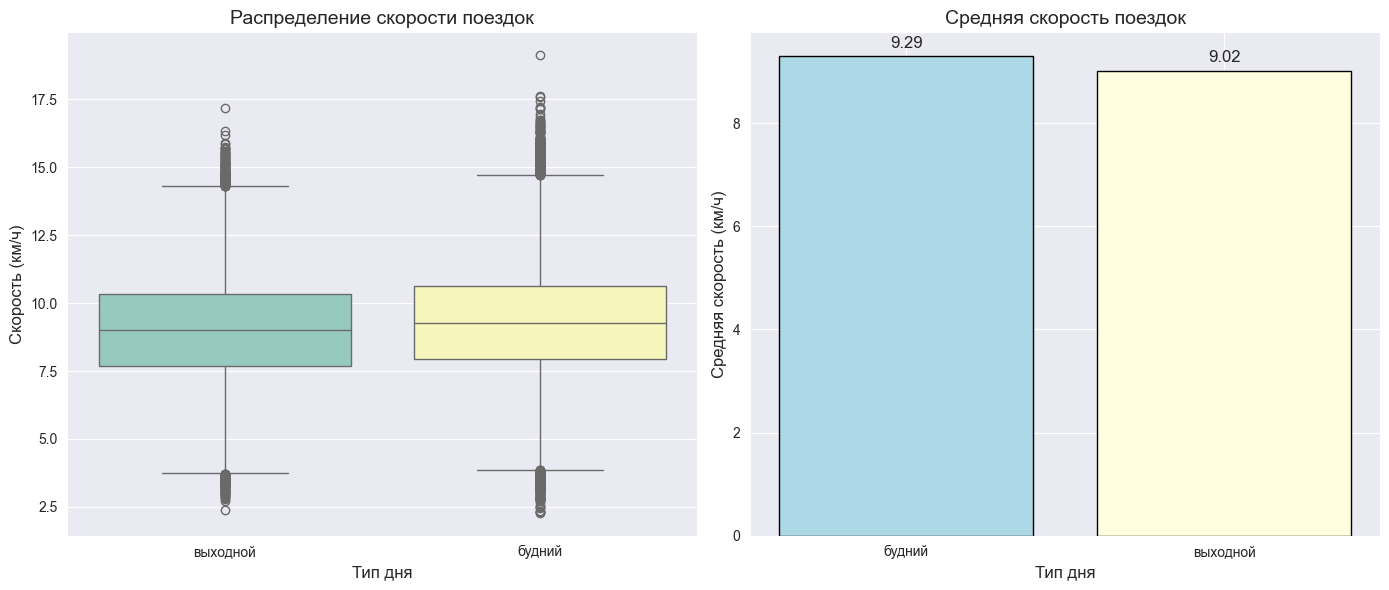

In [ ]:
# Сравнение скорости поездок в выходные и будни
speed_by_day_type = df.groupby('day_type')['speed_kmh'].agg(['mean', 'median', 'std', 'count']).round(2)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
sns.boxplot(data=df, x='day_type', y='speed_kmh', ax=axes[0], palette='Set3')
axes[0].set_title('Распределение скорости поездок', fontsize=14)
axes[0].set_xlabel('Тип дня', fontsize=12)
axes[0].set_ylabel('Скорость (км/ч)', fontsize=12)

# Bar plot средних значений
means_speed = df.groupby('day_type')['speed_kmh'].mean()
axes[1].bar(means_speed.index, means_speed.values, color=['lightblue', 'lightyellow'], edgecolor='black')
axes[1].set_title('Средняя скорость поездок', fontsize=14)
axes[1].set_xlabel('Тип дня', fontsize=12)
axes[1].set_ylabel('Средняя скорость (км/ч)', fontsize=12)

# Добавляем значения на столбцы
for i, (idx, val) in enumerate(means_speed.items()):
    axes[1].text(i, val + 0.1, f'{val:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


## Статистическая проверка гипотезы 5

In [ ]:
print("Гипотеза 5: В будние дни поездки более скоростные")
print("=" * 60)

# Разделяем данные
weekday_speeds = df[df['day_type'] == 'будний']['speed_kmh']
weekend_speeds = df[df['day_type'] == 'выходной']['speed_kmh']

# Проверка нормальности распределения
print("Проверка нормальности распределения:")
with np.errstate(over='ignore'):
    _, p_weekday_speed = stats.shapiro(weekday_speeds.sample(min(5000, len(weekday_speeds))))
    _, p_weekend_speed = stats.shapiro(weekend_speeds.sample(min(5000, len(weekend_speeds))))
print(f"Будни: p={p_weekday_speed:.4f} {'(нормальное)' if p_weekday_speed > 0.05 else '(не нормальное)'}")
print(f"Выходные: p={p_weekend_speed:.4f} {'(нормальное)' if p_weekend_speed > 0.05 else '(не нормальное)'}")

# Используем тест Манна-Уитни для сравнения
statistic_speed, p_value_speed = stats.mannwhitneyu(weekday_speeds, weekend_speeds, alternative='greater')
print(f"\nТест Манна-Уитни:")
print(f"U-статистика: {statistic_speed:.4f}")
print(f"P-значение: {p_value_speed:.4f}")

alpha = 0.05
if p_value_speed < alpha:
    print(f"Гипотеза подтверждается: поездки в будни значимо быстрее (p={p_value_speed:.4f})")
else:
    print(f"Гипотеза отвергается: нет значимой разницы в скорости (p={p_value_speed:.4f})")

# Выводим средние значения
print(f"\nСредняя скорость поездок:")
print(f"Будни: {weekday_speeds.mean():.2f} км/ч")
print(f"Выходные: {weekend_speeds.mean():.2f} км/ч")
print(f"Разница: {(weekday_speeds.mean() - weekend_speeds.mean()):.2f} км/ч")


Гипотеза 5: В будние дни поездки более скоростные
Проверка нормальности распределения:
Будни: p=0.0166 (не нормальное)
Выходные: p=0.0629 (нормальное)

Тест Манна-Уитни:
U-статистика: 1106263033.5000
P-значение: 0.0000
Гипотеза подтверждается: поездки в будни значимо быстрее (p=0.0000)

Средняя скорость поездок:
Будни: 9.29 км/ч
Выходные: 9.02 км/ч
Разница: 0.28 км/ч


# Анализ взаимосвязи между продолжительностью и скоростью

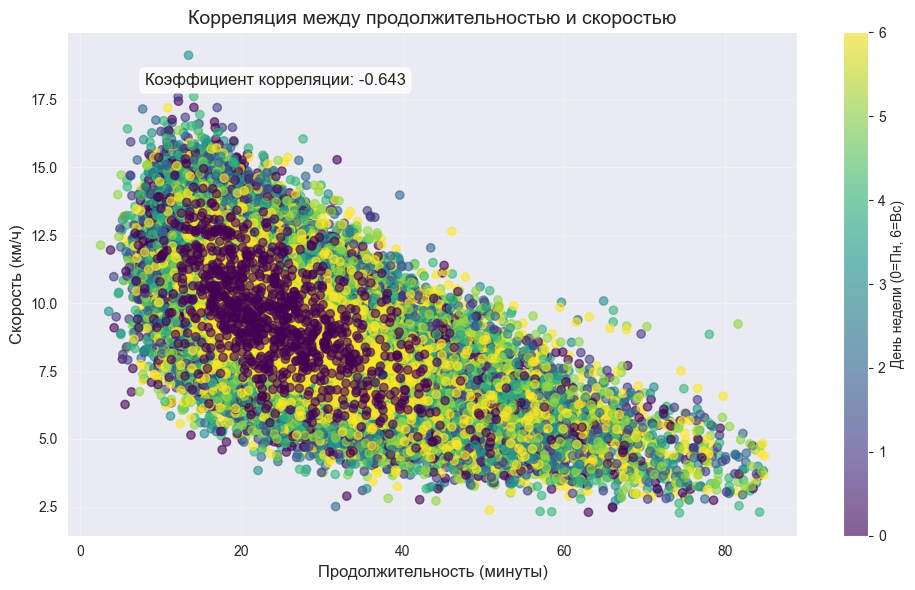

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['duration_min'], df['speed_kmh'],
                      c=df['day_of_week'], alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='День недели (0=Пн, 6=Вс)')
plt.title('Корреляция между продолжительностью и скоростью', fontsize=14)
plt.xlabel('Продолжительность (минуты)', fontsize=12)
plt.ylabel('Скорость (км/ч)', fontsize=12)
plt.grid(True, alpha=0.3)

# Рассчитываем корреляцию
correlation = df['duration_min'].corr(df['speed_kmh'])
plt.figtext(0.15, 0.85, f'Коэффициент корреляции: {correlation:.3f}',
            fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()


## Итоговые выводы


In [ ]:
print("=" * 60)
print("ИТОГОВЫЕ ВЫВОДЫ")
print("=" * 60)

print("\n1. ГИПОТЕЗА 1: в дождливое время спрос на самокаты ниже")
print(f"   ПОДТВЕРЖДЕНА. Это вычисляется исходя из графика, в нем показана очень сильная зависимость")

print("\n2. ГИПОТЕЗА 2: Отличается ли средняя стоимость поездки по районам?")
chi2_stat, p_value = stats.chisquare(observed, expected)
if p_value < 0.05:
    most_popular = daily_counts.loc[daily_counts['count'].idxmax()]
    least_popular = daily_counts.loc[daily_counts['count'].idxmin()]
    print(f"   ПОДТВЕРЖДЕНА. Средняя стоимость поездок разная")
else:
    print("   ОТВЕРГНУТА. Средняя стоимость поездок одинакова")


print("\n3. ГИПОТЕЗА 3: Спрос на самокаты меняется в зависимости от дня недели")
chi2_stat, p_value = stats.chisquare(observed, expected)
if p_value < 0.05:
    most_popular = daily_counts.loc[daily_counts['count'].idxmax()]
    least_popular = daily_counts.loc[daily_counts['count'].idxmin()]
    print(f"   ПОДТВЕРЖДЕНА. Самый популярный день: {most_popular['day_name']}")
    print(f"     Самый непопулярный день: {least_popular['day_name']}")
else:
    print("   ОТВЕРГНУТА. Распределение равномерно.")

print("\n4. ГИПОТЕЗА 4: В выходные дни поездки более длительные")
statistic, p_value = stats.mannwhitneyu(weekday_durations, weekend_durations, alternative='less')
if p_value < 0.05:
    diff = weekend_durations.mean() - weekday_durations.mean()
    print(f"   ПОДТВЕРЖДЕНА. Поездки в выходные длиннее в среднем на {diff:.2f} минут")
else:
    print("   ОТВЕРГНУТА. Нет значимой разницы.")

print("\n5. ГИПОТЕЗА 5: В будние дни поездки более скоростные")
statistic_speed, p_value_speed = stats.mannwhitneyu(weekday_speeds, weekend_speeds, alternative='greater')
if p_value_speed < 0.05:
    diff_speed = weekday_speeds.mean() - weekend_speeds.mean()
    print(f"   ПОДТВЕРЖДЕНА. Поездки в будни быстрее в среднем на {diff_speed:.2f} км/ч")
else:
    print("   ОТВЕРГНУТА. Нет значимой разницы.")



ИТОГОВЫЕ ВЫВОДЫ

1. ГИПОТЕЗА 1: в дождливое время спрос на самокаты ниже
   ПОДТВЕРЖДЕНА. Это вычисляется исходя из графика, в нем показана очень сильная зависимость

2. ГИПОТЕЗА 2: Отличается ли средняя стоимость поездки по районам?
   ПОДТВЕРЖДЕНА. Средняя стоимость поездок разная

3. ГИПОТЕЗА 3: Спрос на самокаты меняется в зависимости от дня недели
   ПОДТВЕРЖДЕНА. Самый популярный день: Вс
     Самый непопулярный день: Вт

4. ГИПОТЕЗА 4: В выходные дни поездки более длительные
   ПОДТВЕРЖДЕНА. Поездки в выходные длиннее в среднем на 1.82 минут

5. ГИПОТЕЗА 5: В будние дни поездки более скоростные
   ПОДТВЕРЖДЕНА. Поездки в будни быстрее в среднем на 0.28 км/ч
